# DETECT: tutorial

Developed by Tobias Géron at the University of Toronto.

This code was developed to help better quantify detection thresholds with the Rubin pipelines. The current Rubin pipelines define detections with a simple SNR threshold. However, this becomes difficult when there is a bright background galaxy, or when the datapoint in question has a magnitude around the detection threshold (~23-24). How confident are we that this detection is real? This code was created with a specific science goal in mind: pre-SN variability. However, it can be used in any science context where you want to better understand the detection thresholds. This code helps to answer the following question: "Using the Rubin pipelines, in this specific epoch, using this specific template, how likely is it that a datapoint of X mag is detected?" 

This is answered using a series of source injection (see Parts I-II), image subtraction (see Part III), and forced photometry (see Part IV). This is repeated for multiple injection locations and multiple magnitude ranges. The output of the pipeline is a recovery curve (see Part VII), which you can use to compute the 80% or 50% detection fraction thresholds (i.e. the magnitude where X% of sources with magnitude Y would be detected with the Rubin pipelines at this specific epoch and this specific template; see Part VIII).

This is an in-depth tutorial on how to use this package, which explains the different steps involved in detail.

### Import packages, and config
Before we start, we must import everything we need. We use a lot of packages, both part of the Rubin pipeline and others.

In [1]:
from detect import * # Import all functions

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

# Various Rubin pipelines
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

In [2]:
# Additional config
service = get_tap_service("tap")
assert service is not None

butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

afwDisplay.setDefaultBackend('matplotlib')

set_logging_level('WARNING')

### Part 0: Load data

In this first part, we will load some data from DP1 to run this pipeline on. In this scenario, we have a specific RA/Dec pair that we are interested in. Let's query the `DiaObject` table at those coordinates to see whether Rubin has found something there. If nothing is found, then Rubin will also not have done forced photometry on this location. This makes things a bit more complicated. To get around this, you could query all visit_images that cover that RA/Dec pair, and just do forced photometry yourself. But in this tutorial, we will assume that we have found a valid diaObjectId.

In [3]:
ra_sn, dec_sn = 58.335054, -48.750303

band = 'r'

In [4]:
query = "SELECT ra, dec, diaObjectId "\
        "FROM dp1.DiaObject "\
        f"WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS',{ra_sn}, {dec_sn}, {10/60/60})) = 1 "

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

df_diaobj = job.fetch_result().to_table()
print(f"\nFound {len(df_diaobj)} source(s)")

Job phase is COMPLETED

Found 1 source(s)


In [5]:
df_diaobj

ra,dec,diaObjectId
deg,deg,
float64,float64,int64
58.334939507315646,-48.75027587334623,592914119179370575


In [6]:
# Select the correct object
diaobjectid = df_diaobj['diaObjectId'][0]

We will now use that `diaObjectId` to query the `ForcedSourceOnDiaObject` table to obtain the light curve around that object. 

In [7]:
query = "SELECT fsodo.coord_ra, fsodo.coord_dec, fsodo.diaObjectId, fsodo.visit, fsodo.detector, fsodo.band, vis.skyRotation, "\
        "fsodo.tract, fsodo.patch, fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, fsodo.psfFlux, fsodo.psfFluxErr, vis.expMidptMJD "\
        "FROM dp1.ForcedSourceOnDiaObject as fsodo "\
        "JOIN dp1.Visit as vis ON vis.visit = fsodo.visit "\
        f"WHERE fsodo.diaObjectId = {diaobjectid} AND fsodo.band = '{band}'"

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

df_exposure = job.fetch_result().to_table()
print(f"\nFound {len(df_exposure)} sources")

Job phase is COMPLETED

Found 10 sources


In [8]:
# Adding some extra columns...
df_exposure['psfDiffMag'] = njy_to_mag(df_exposure['psfDiffFlux'])
df_exposure['psfDiff_snr'] = df_exposure['psfDiffFlux'] / df_exposure['psfDiffFluxErr']
df_exposure['detected'] = [True if df_exposure['psfDiffFlux'][i] - 5* df_exposure['psfDiffFluxErr'][i] > 0 else False for i in range(len(df_exposure))]
df_exposure['5sigma_mag'] = njy_to_mag(5* df_exposure['psfDiffFluxErr'])
df_exposure['5sigma_flux'] = 5* df_exposure['psfDiffFluxErr']
df_exposure = df_exposure.to_pandas()

df_exposure.head()

,coord_ra,coord_dec,diaObjectId,visit,detector,band,skyRotation,tract,patch,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD,psfDiffMag,psfDiff_snr,detected,5sigma_mag,5sigma_flux
0,58.33494,-48.750276,592914119179370575,2024120800420,2,r,53.504779,2394,28,3085.929932,200.940002,10593.000000,193.145996,60653.233153,22.676535,15.357470,True,23.894909,1004.700012
1,58.33494,-48.750276,592914119179370575,2024111800097,8,r,293.702197,2394,28,-736.094971,194.270004,7324.600098,183.860992,60633.099718,NaN,-3.789031,False,23.931561,971.350021
2,58.33494,-48.750276,592914119179370575,2024111700344,2,r,68.683768,2394,28,-493.553009,339.725006,7918.330078,334.776001,60632.234874,NaN,-1.452802,False,23.324756,1698.625031
3,58.33494,-48.750276,592914119179370575,2024112600182,8,r,293.090221,2394,28,-563.911011,138.395996,3009.510010,123.559998,60641.120656,NaN,-4.074619,False,24.299766,691.979980
4,58.33494,-48.750276,592914119179370575,2024112600183,8,r,293.231112,2394,28,-794.838989,125.908997,2324.969971,112.601997,60641.121511,NaN,-6.312805,False,24.402433,629.544983


In [9]:
# Remove duplicate days to make it clearer
df_exposure['mjd_int'] = df_exposure['expMidptMJD'].astype(int)
df_exposure = df_exposure[df_exposure.duplicated(subset = 'mjd_int', keep = 'first') == False].reset_index(drop=True)
df_exposure = df_exposure.drop(columns=['mjd_int'])

# Sort by mjd
df_exposure = df_exposure.sort_values(by='expMidptMJD').reset_index(drop=True)

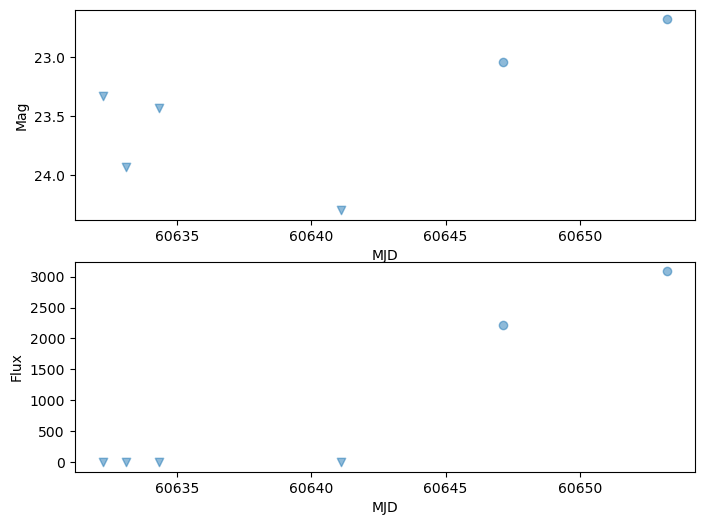

In [10]:
c = 'C0'

plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['psfDiffMag'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['5sigma_mag'][i], marker = 'v', c = c, alpha = 0.5)
        

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')


plt.subplot(2,1,2)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['psfDiffFlux'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['expMidptMJD'][i], mag_to_njy(df_exposure['5sigma_flux'][i]), marker = 'v', c = c, alpha = 0.5)
        
plt.xlabel('MJD')
plt.ylabel('Flux')

plt.show()

Select one specific epoch to run the code on.

In [11]:
i = 5

mjd = df_exposure['expMidptMJD'][i]
visit = df_exposure['visit'][i]
detector = df_exposure['detector'][i]
tract = df_exposure['tract'][i]
patch = df_exposure['patch'][i]
dataId = {'band' : band, 'visit': visit, 'detector': detector, 'tract' : tract, 'patch' : patch}

# Get calexp, template and sources from butler
calexp = butler.get('visit_image', dataId=dataId)
template = butler.get('template_coadd', dataId=dataId)
diff = butler.get('difference_image', dataId=dataId)

# Obtain all the sources in the calexp. These are used later, but it is best to load them now. 
sources = source_detection(calexp)

# Get the SN mag from df_exposure. Can be either actual value, or 5sigma detection. Doesn't matter too much,
# the final code will only use this as an initial estimate.
sn_mag = df_exposure['psfDiffMag'][i] if df_exposure['detected'][i] else df_exposure['5sigma_mag'][i]

We visualise the images below. It is often good practice to visually inspect your cutouts to make sure that nothing is obviously wrong. Things to look out for include making sure that your galaxy is on the edge of the image, and that the template does not contain any obvious artifacts. Note that the template image might be oriented differently compared to the science image. This is because, by default, the templates and visit images are located on different grids. This can easily be solved by warping the template image using: 

```
warped_template = warp_exposure(template,calexp)
```

However, we do this automatically inside our pipeline when needed, so we do not worry about this here.

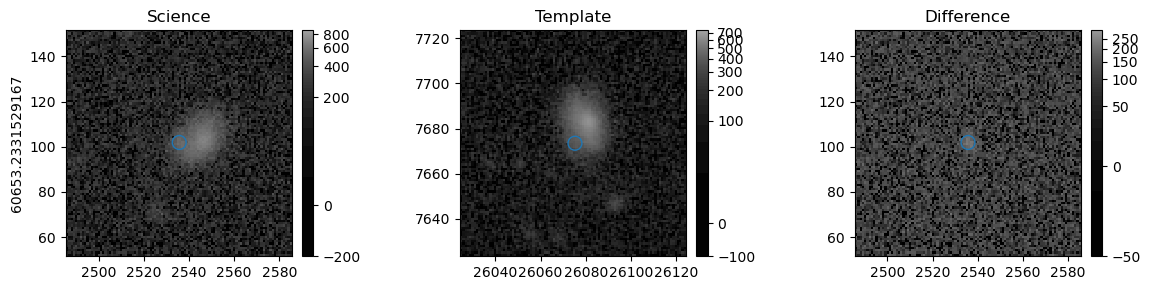

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

plot_image(calexp, ax = ax[0], title = f'Science', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')
plt.ylabel(mjd)
plot_image(template, ax = ax[1], title = f'Template', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')
plot_image(diff, ax = ax[2], title = f'Difference', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 20, scale = 'asinh')

plt.tight_layout()
plt.show()

Finally, we also create cutouts to speed up our code.

In [13]:
cutout_size = 400 #in arcsec
calexp_cutout = cutout_exposure(calexp, ra_sn, dec_sn, size = cutout_size, size_units = 'sky')
template_cutout = cutout_exposure(template, ra_sn, dec_sn, size = cutout_size+20, size_units = 'sky') #templates have a buffer region around edges. Need to account for that, hence the +20
diff_cutout = cutout_exposure(diff, ra_sn, dec_sn, size = cutout_size, size_units = 'sky')

Now we're ready to go!

### Part I: Finding injection locations
The first step of the pipeline involves selecting locations in the image to inject the fake SN in. We can easily do that with the function `create_injection_locations()`. Note that this function does not do the actual injection, but finds the appropriate locations. 

The injection locations are found by first smoothening the exposure, and then finding injection sites that have similar flux values to the SN site in the template image. This function therefore also requires the template as an argument. There are multiple arguments that help to finetune this process. First, you must specify the number of desired injection sites with `n_injection`. You can specify the smoothening filter and the size of the filter in pixels by changing `smooth_function` and `smooth_filter_size`. The defaults for these arguments are 'median' and 10, respectively. 

As you might expect, it is easier to find suitable injection locations for large, nearby galaxies than for small, distant galaxies. These additional parameters are described in more detail below. Also note that we're zooming in on the SN in the plots below (by using `plot_zoom = True`), to better visualise the results.

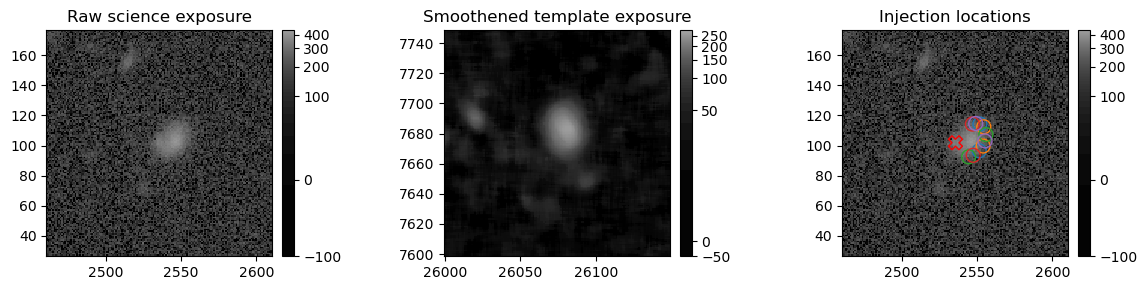

In [14]:
injection_locations = create_injection_locations(calexp_cutout, template_exposure = template_cutout, n_injections = 10,
                                                 sn_position = (ra_sn,dec_sn), max_dist = 20, p_threshold = 5, 
                                                 psf_flux_threshold = 0.001, psf_sigma = 0, min_dist_across_iterations = 0.4, 
                                                 plot = True, plot_zoom = True, plot_zoom_size = 30)

Note the different coloured rings in the image above. To save time, the pipeline will inject multiple fake SN at the same time and analyse them together. All injection locations with same colour will be injected together (i.e. they belong to the same 'injection iteration'). These locations are combined in such a way so that they do not overlap. This process can be tweaked using the parameters described below. 

As you might expect, it is easier to find suitable injection locations for large, nearby galaxies than for small, distant galaxies. Thus, there are a few parameters that you can finetune to select the most optimal injection locations for your specific scenario. They are: 

- `p_threshold`: int, should be between 0 and 100, default is 5. This parameter is used to finetune the precision with which the injection locations are found. The default `p_threshold = 5` means that any injection site will have a flux within 5% of the flux of the location of the SN on the template image. Largest values make it easier to find locations, but makes it less precise.  

- `psf_flux_threshold`: float, between 0 and 1, default is 0.001. For every possible injection location iteration, we calculate a minimum distance it needs to be separated from other possible injection locations in the same injection iteration. This is done so that we can speed this pipeline up by injecting multiple targets at the same time. However, we want to be cautious as we want to avoid any possibility of overlap and leaking into nearby injection locations. This is done by looking at the PSF at each possible injection location and find the distance at which `(1 - psf_flux_threshold) %` of the flux of the normalized PSF is contained. That percentage can be changed with this parameter. The default is 0.001, i.e. 1 - 0.001 = 0.999, thus we find the radius within which 99.9% of the flux is contained. Higher values will make it easier to find injection locations, but at the cost of leaking and less accurate final results. 

- `psf_sigma`: float, default 0. To make sure that we are avoiding any leaking between injection locations in the same injection iteration, it is possible to additionally calculate the $\sigma$ of the PSF and add a multiple of it on top of the radius defined with `psf_flux_threshold`. This multiple can be changed with the parameter `psf_sigma` (the default is 0). You can disable this feature by setting this equal to 0. Disabling this makes it easier to find injection locations.     

- `min_dist_across_iterations`: float, default is 0.4 arcsec. Even across injection iterations, we do not want to simply choose another injection location that lies in the adjacent pixel. So whenever we find a suitable injection location, we also mark all the other possible locations that are within X arcsec as unuseable. You can disable this behaviour by setting this to 0. Lower values makes it easier to find injection locations.

- `max_dist`: float, default is 50 arcsec. This is the is maximum distance of a possible injection location to SN in arcsec. This is to avoid that injection locations are found in other galaxies. You can disable this behaviour by setting this to np.inf. 

We strongly suggest that users experiment with the parameters described here. The default options work well for medium-sized galaxies, but it is possible to make them more strict (which means more precise results) for targets in larger galaxies. Similarly, you will have to relax these criteria for targets in smaller or more distant galaxies, otherwise it is possible that not enough injection locations are found.

Finally, I want to mention that, while injecting multiple sources at the same time does make this code run faster, it is not always straight-forward to find suitable injection locations. If you are not happy with the injection locations found with the parameters above, you can always force the code to only inject one source at the time, by setting `max_inj_per_round = 1`. Additionally setting `min_dist_across_iterations = 0` and increasing `p_threshold` will further help in situations where this is an issue.

### Part II: Injecting sources
The second part of the pipeline involves actually injecting the sources. This package contains a fast and easy way to do that. Here, we will inject all sources of the first injection iteration. 

We first need to create an injection catalog. This can easily be done with `create_injection_catalog()`, see above. This is then used in `inject_source()` to inject it in an exposure.

Note that we have to use full images in the injection routine because of how the Rubin source injection pipelines work. However, we can inject in the full image, and then create a cutout of the injected image. We can still use the cutouts to speed up finding the injection locations in the previous step, though. 

In [15]:
# Create injection locations and select the first injection iteration (see step above)
injection_locations = create_injection_locations(calexp_cutout, template_exposure = template_cutout, n_injections = 10,
                                                 sn_position = (ra_sn,dec_sn), max_dist = 20, p_threshold = 5, 
                                                 psf_flux_threshold = 0.001, psf_sigma = 0, min_dist_across_iterations = 0.4, 
                                                 plot = False)

injection_locations = injection_locations[0]
ra_inj = np.array(injection_locations)[:,0]
dec_inj = np.array(injection_locations)[:,1]

# Create the injection catalog 
injection_catalog = create_injection_catalog(ra_inj,dec_inj,['Star']*len(injection_locations),[sn_mag]*len(injection_locations))

# Inject the source
inj_calexp, _ = inject_source(calexp, injection_catalog, band = band)

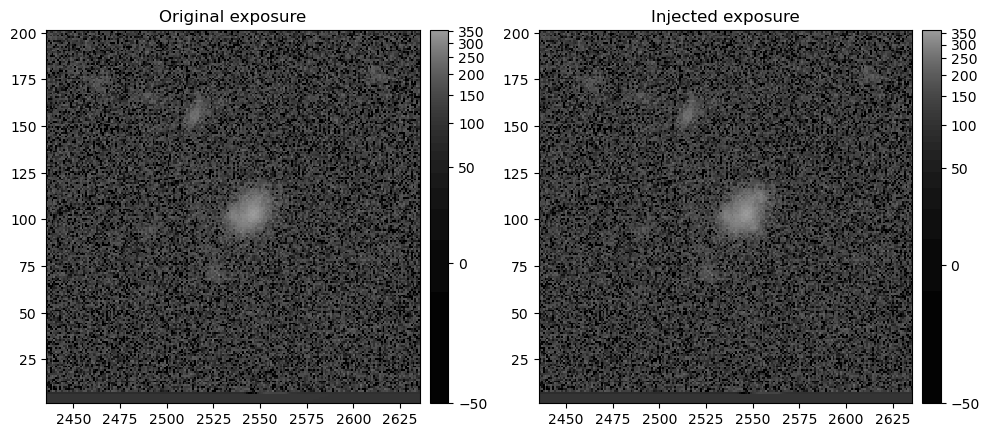

In [16]:
# Visualise injection

fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_image(calexp, ax = ax[0], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Original exposure')
plot_image(inj_calexp, ax = ax[1], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Injected exposure')
plt.tight_layout()
plt.show()

In [17]:
# create a cutout of the injected science image
inj_calexp_cutout = cutout_exposure(inj_calexp, ra_sn, dec_sn, size = cutout_size, size_units = 'sky')

Note that, if the magnitude of the injected sources is faint, you might not see anything in the images above.

### Part III: Image subtraction
Now that we have our injected image, we can perform image subtraction with a template. We use the LSST AlardLuptonSubtractTask, which is wrapped in the `subtract_images()` function. In addition to the injected exposure and the template, this task also needs other sources in the image that we obtained in the beginning of this notebook.

We use the AlardLuptonSubtractTask to do the subtraction. Note that you can also pass a `config` parameter to `subtract_images()`. This should be a `lsst.ip.diffim.subtractImages.AlardLuptonSubtractConfig`. This allows you to finetune the details of the subtraction. If you do not specify this parameter, we will use the default config. We srongly recommended to keep this to the default config, unless you are confident in what you want to change. 

Note for DP1 specifically: the exact settings, configuration and information needed to use the Rubin image subtraction pipelines that were used to create the difference images in DP1 were not made accessible to the broader community. We are able to closely reproduce the DP1 difference images here, but not exactly. This will be changed whenever this situation changes, presumably for DP2. 

In [18]:
diff_cutout = subtract_images(template_cutout, inj_calexp_cutout, sources, apply_source_filtering = True)

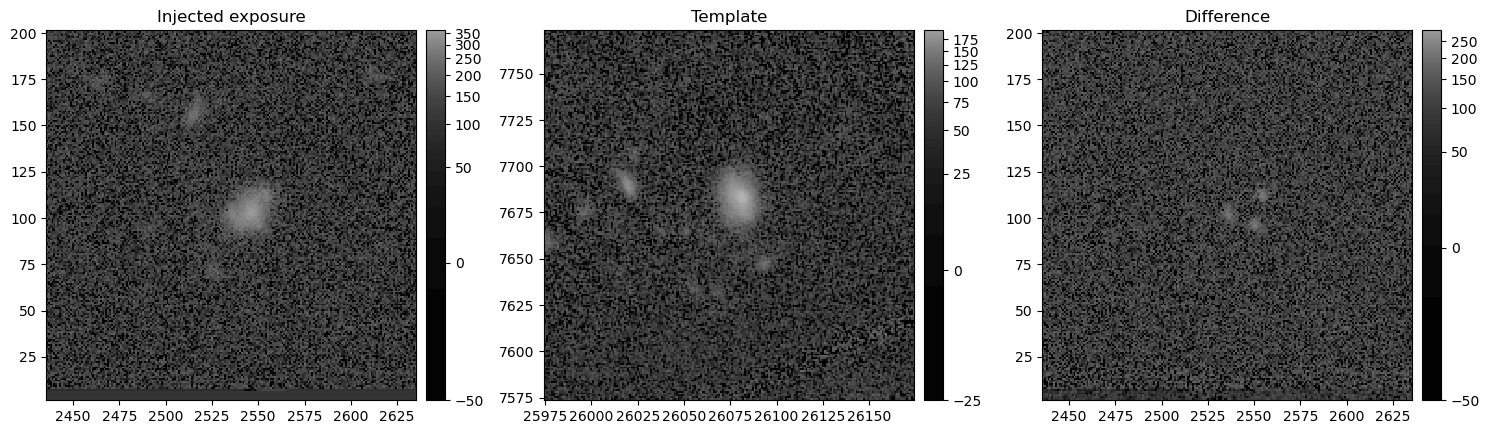

In [19]:
# Visualise subtraction
fig, ax = plt.subplots(1,3, figsize=(15, 9))
plot_image(inj_calexp, ax = ax[0], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Injected exposure')
plot_image(template, ax = ax[1], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Template')
plot_image(diff_cutout.difference, ax = ax[2], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Difference')
plt.tight_layout() 
plt.show()

### Part IV: Forced photometry

Now we will perform forced photometry on the subtracted difference image at these injection locations. This can be done with the `forced_photometry()` function. It needs the difference image obtained through the steps above, and the previously defined injection locations.

In [20]:
df_forced = forced_photometry(diff_cutout.difference, injection_locations)
df_forced.head()

,base_PsfFlux_nJy,base_PsfFlux_nJyErr,base_PsfFlux_SNR,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_instSNR,base_PsfFlux_area
0,3321.831165,193.438321,17.172560,3321.831165,193.438321,17.172560,93.615967
1,3111.631341,191.998280,16.206558,3111.631341,191.998280,16.206558,93.756081


### Part V: Combining the above
So far we have covered injecting sources, image subtraction and forced photometry (steps II-IV). You can do these steps separately as shown above. However, to make things much easier, the fuction `inject_subtract_photometry()` does all of these steps automatically in the correct order. This function needs the science image, injection locations, sn_mag, the other sources in the image, and the template.

In order to speed things up significantly, we can pass an additional `cutout_size` argument. This will create a cutout of the image with a size of X arcsec around the SN. The source injection will still happen on the full image, as required by the Rubin pipelines, but the image subtraction will only happen on the cutouts. This speeds things up *significantly* and we highly recommend doing this. The only caveat is that there should still be enough sources in the background to do the subtraction with. About 200 sources seems good, which in this case corresponds to a cutout_size of roughly 400 arcsec. More sources are better, at the cost of time. If you receive a warning from `alardLuptonSubtract` that the `Spatial background model poorly constrained`, consider increasing the `cutout_size`.

Note that the plot only shows one injection iteration, not all of them. 

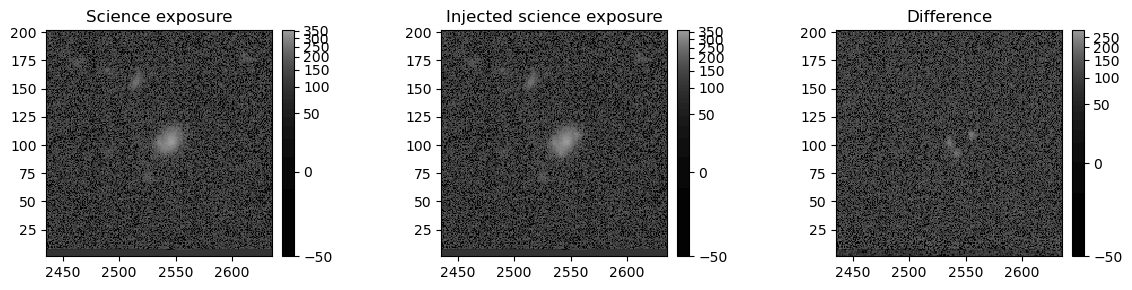

,base_PsfFlux_nJy,base_PsfFlux_nJyErr,base_PsfFlux_SNR,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_instSNR,base_PsfFlux_area,n_injection_iteration,injection_x,injection_y,injection_ra,injection_dec,injection_id
0,3047.794371,192.104145,15.865323,3047.794371,192.104145,15.865323,93.756081,0,2554.474330,112.463397,58.334844,-48.749109,0_0
1,3383.734667,193.545182,17.482919,3383.734667,193.545182,17.482919,93.615967,0,2550.617429,95.922027,58.333904,-48.749824,0_1
0,3124.753080,193.178743,16.175450,3124.753080,193.178743,16.175450,93.696884,1,2548.215918,94.133711,58.333901,-48.749990,1_0
1,3263.902690,191.774308,17.019499,3263.902690,191.774308,17.019499,93.680138,1,2555.665175,110.864851,58.334676,-48.749108,1_1
0,3194.305778,192.035626,16.633923,3194.305778,192.035626,16.633923,93.655281,2,2554.024525,99.701825,58.333994,-48.749546,2_0


In [21]:
# Get the injection locations, using only the cutout
injection_locations = create_injection_locations(calexp_cutout, template_exposure = template_cutout, n_injections = 10,
                                                 sn_position = (ra_sn,dec_sn), max_dist = 20, p_threshold = 5, 
                                                 psf_flux_threshold = 0.001, psf_sigma = 0, min_dist_across_iterations = 0.4, 
                                                 plot = False)

# Do source injection - image subtraction - forced photometry
df_results = inject_subtract_photometry(calexp, injection_locations = injection_locations, injection_mag = sn_mag, sources = sources, 
                     template_exposure = template, plot = True, plot_zoom = True, sn_position = (ra_sn,dec_sn), cutout_size = cutout_size)

df_results.head()

### Part VI: Estimate background noise

Before we continue, we need to talk about image subtraction a bit more. The subtraction pipeline is not perfect. Image subtraction is a difficult problem, especially when there is a bright background galaxy. The Rubin pipelines sometimes register some pixels as detections (SNR > 5 in the difference image), even when there is not anything there. To investigate whether this is the case for your particular image, you can use `measure_snr_on_img()`.

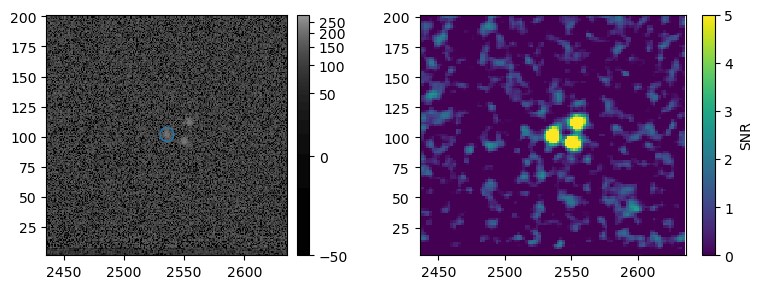

In [22]:
_ = measure_snr_on_img(diff_cutout.difference, (ra_sn,dec_sn), zoom_size = 40, stepsize = 2, plot = True)


There can be a lot of detections at various places in this image, even when there shouldn't be. This isn't always the case, but typically happens when the background galaxy is very bright. This will affect both the original SN measurement made by the Rubin pipelines, as well as the measurements we make ourselves. We can estimate the contribution of this issue on the original SN measurement. This is done by finding all pixels that have similar flux values to the SN site in the template image, measuring what flux they have in the science image, and use that to correct the SN flux. This is done with the `estimate_sn_background()` function. Ideally you want the background flux to be centered around zero. But if it isn't, then you can subtract the median from the sn mag.

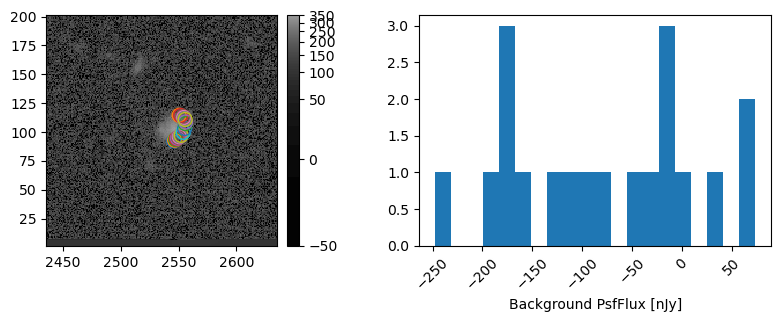

In [23]:
df_background = estimate_sn_background(calexp, template, sources = sources, sn_position = (ra_sn,dec_sn),
                             p_threshold = 5, plot = True, cutout_size = cutout_size)

# First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
sn_njy = mag_to_njy(sn_mag) - np.median(df_background['base_PsfFlux_nJy'])
sn_mag_new = njy_to_mag(sn_njy)

In [24]:
df_background.head()

,base_PsfFlux_nJy,base_PsfFlux_nJyErr,injection_id,injection_ra,injection_dec
0,-247.333855,191.895202,0_0,58.333898,-48.750157
1,-198.104637,192.382547,0_1,58.333899,-48.750101
2,-127.273760,192.730217,0_2,58.333900,-48.750046
3,-75.618573,193.178637,0_3,58.333901,-48.749990
4,31.447721,193.557386,0_4,58.333902,-48.749935


### Part VII: Create a recovery curve
We are almost there! The goal of this package is to generate a recovery curve. We can do that manually by calling `inject_subtract_photometry()` multiple times for different magnitudes (sn_mags), and checking what fraction of injected sources are detected at each value of sn_mag. However, this is done automatically with the `recovery_curve()` function. 

This function needs the sn_mag, the science exposure, the template exposure, the other sources in the image and the SN position as inputs. Additional settings can be adjusted through the `recovery_curve_config` class. 

There are a lot of settings that can be tweaked, but we'll go through some important ones here. The `recovery_curve()` fuction creates a range of sn magnitudes to check. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps = [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20. The precision on the detection fraction depends on `n_injections`. If n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections). The default is 10. Additionally, `cutout_size` determines the size of the cutout. As discussed above, smaller cutouts significantly speed things up, but we still need enough sources in the image to properly do the subtraction. The default option is to not use a cutout, but we strongly suggest to change this to your needs. In this case, a cutout_size of 400 arcsec seems to do the job. Additionally, as covered above, the subtraction pipeline doesn't always work perfectly. Some injection locations will always register as detections. We can account for that using the `subtract_background` parameter (default is True). If enabled, we first measure the baseline background before injecting fake sources and then subtract that from the measured value before determining whether the injected source is detected. Finally, the `n_jobs` parameter is used to parallelise the code. It should not exceed the number of available CPU cores.

Running this might take a few minutes per epoch. The `n_mag_steps`, `n_injection`, `cutout_size` and `n_jobs` parameters are the most important arguments to finetune if the pipeline takes too long. The biggest time sink is the Rubin image subtraction. Unfortunately, the nature of this pipeline requires us to use that, so we cannot make any improvements there. 

The `recovery_curve()` function returns a pandas DataFrame where every row represents a magnitude (`sn_mag`) and in what fraction of injections this was recovered (`detected`). You can expand the output of this function by doing `expand_output = True`, in which case a more detailed DataFrame is returned. In this case, each row represents a single injection location over a single inject sn magnitude. For most purposes, the smaller table is good enough. You can obtain the former (concise) table from from the latter (extended) table by doing: 

`df_summary = recovery_summary(df_recovery)`

Finally, it is good practice to pass the complete images you obtain from Rubin. We create cutouts within the function where appropriate. This also ensures that the wcs of each image behaves as expected.

Note that this may take a while to run. 

  0%|          | 0/5 [00:00<?, ?it/s]

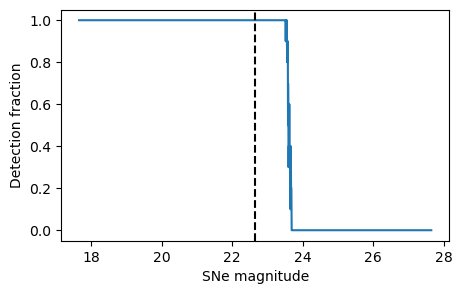

In [25]:
config = recovery_curve_config()

# General config
config.plot = True
config.n_injection = 10 
config.n_mag_steps = [4,4,4,8,20]
config.cutout_size = 400 # Strongly encouraged to add cutout size to speed things up.
config.n_jobs = 4 # Assuming we have 4 cores available. 


# Config to select injection locations. The values for these parameters were decided in Part I.
config.p_threshold = 5
config.psf_flux_threshold =  0.001
config.psf_sigma = 0
config.min_dist_across_iterations = 0.4
config.max_dist = 20


df_recovery = recovery_curve(sn_mag = sn_mag_new, science_exposure = calexp, template_exposure = template, 
                sources = sources, sn_position = (ra_sn,dec_sn), config = config)

In [26]:
df_recovery

,sn_mag,base_PsfFlux_nJy,base_PsfFlux_nJyErr,base_PsfFlux_SNR,detected,background_nonzero_flag
0,17.650250,327569.677895,272.925427,1200.243550,1.0,0.0
1,20.983584,15215.878752,272.922683,55.752202,1.0,0.0
2,22.650250,3334.172086,272.922489,12.217246,1.0,0.0
3,22.983584,2414.352418,272.922641,8.846579,1.0,0.0
4,23.316917,1764.735657,272.922724,6.466414,1.0,0.0
5,23.450250,1551.861271,272.922690,5.686435,1.0,0.0
6,23.479880,1548.098550,272.922609,5.672525,1.0,0.0
7,23.509509,1513.240918,272.922686,5.544525,1.0,0.0
8,23.517975,1454.942576,272.922661,5.330798,0.9,0.0
9,23.526441,1487.637689,272.922617,5.450750,1.0,0.0


Here is a description of some of the remaining options in `recovery_curve_config()`. A complete list can be found in the README.md.

**Description parameters** 

We try to be smart while sampling the recovery curve. We will have multiple rounds of sampling and slowly zoom in to the
region where the curve goes from 1 to 0. The following parameters define this process.  
`n_mag_steps`: list of ints. Defines how many mag steps in each iteration. Better to start low, and go up. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps == [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20.    
`sampling_buffer`: float. During the first iteration, we create a range around the sn_mag. The buffer defines how far out on each side.   
`mag_limits`: list of floats. If the transition region is not found in the first iteration, we simply set the limits of the search to this.  

Related to image smoothing:  
`injection_method`: can be either 'random' or 'smooth'. When random, we just return random pixels in the inmage. When smooth, we first smooth the template image, and then try to find pixels that are similar to the target SN. Very highly recommended to use smooth.  
`smooth_function`: the function used to smooth.  
`smooth_filter_size`: int. The size of the filter, in pixels.  

Related to finding injection locations:  
`n_injections`: int or list of ints. The amount of injections at each iteration. The precision on the detection fraction depends on this. E.g. if n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections).  
`max_inj_per_round`: int. The maximum number of injections done per injection iteration. We try to speed the code up by selecting injection locations that can be injected, subtracted and measured together without influencing each other. If you do not want this behaviour, and prefer to only inject one fake source at the time, you can set this variable to 1.  
`p_threshold`: int. We try to find injection sites that are similar to the target SN. Every injection site will be p_threshold percent 
within the value of the pixel at the SN location in the template image.  
`psf_flux_threshold`: float. Used when creating the injection iterations. We do not want to plce injection sites too close together. We look at the PSF of each injection location and find the distance at which 1 - psf_flux_threshold of the flux of the normalized PSF is contained and make sure to exclude other sites within that range.  
`psf_sigma`: In addition to the above, we also calculate the std of the PSF and add a psf_sigma multiple of that to this radius.   

Remaining parameters:    
`subtraction_config`: We use the AlardLuptonSubtractTask to do the subtraction. Note that you can also pass a `config` parameter to `subtract_images()`. This should be a `lsst.ip.diffim.subtractImages.AlardLuptonSubtractConfig`. This allows you to finetune the details of the subtraction. If you do not specify this parameter, we will use the default config. Strongly recommended to keep this to default, unless you're confident in what you want to change.
`snr_threshold`: float. What SNR threshold defines a detection. Default Rubin value is 5.   
`subtract_background`: bool, default True. Whether to automatically subtract the background.  
`cutout_size`: int. We recommend to input the full images, but we fill create a cutout ourselves for the majority of the tasks to speed things up. Units are arcsec. Default is NaN, but very highly recommended to use a value. It needs to be high enough to still include other sources for the subtraction. Around 300-500 usually seems appropriate.  
`sn_position_units`: string. Whether the sn_position is in pixel units or sky units.  
`plot`: Whether to automatically output plots.  
`expand_output`: bool. If True, we expand the output to contain much more detail. You can recover the summarised dataframe by doing: `df_recovery = recovery_summary(df_expanded_output)`.  
`n_jobs`: Used to specify how many parallel processes should be used to complete this. Should not exceed number of available CPU cores. Can disable this functionality by doing n_jobs = 0. Parallelisation happens over inject_subtract_photometry() with different sn_mags. 
 

### Part VIII: Finding detection threshold values

We now have the recovery curve, but we still have to calculate the actual magnitude detection threshold values. Looking at the recovery curve, we notice that there are two important transition points: $x_1$ and $x_2$. At magnitudes brighter than $x_1$, the recovery curve equals 1, i.e. the injected signal is always detected. At magnitudes fainter than $x_2$, the recovery curve equals 0, i.e. the injected signal is never detected. The interesting stuff happens between $x_1$ and $x_2$. We can fit the recovery curve with a model where we assume flat lines y = 1 and y = 0 before and after the transition points and linearly in between. I.e.:

$$
y = 
\begin{cases} 
1, & \text{if } x < x_1, \\
mx + b, & \text{if } x_1 \leq x \leq x_2, \\
0, & \text{if } x > x_2, 
\end{cases}
$$

where

$$ m = \frac{-1}{x_2-x_1},\;\;\;  b = \frac{x_2}{x_2 - x_1}.$$

This has the added benefit that we can solve for any detection threshold, even if we did not explicitely sample it. This is done automatically using the `find_thresholds()` function. It needs the summarised output of `recovery_curve()` as input, as well as the detection fractions thresholds you want. It will output the corresponding magnitude thresholds.

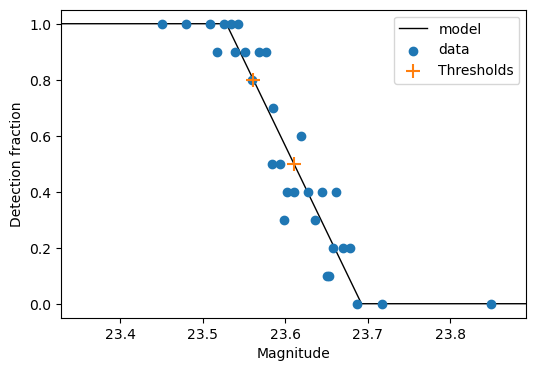

In [27]:
mag_limits = find_thresholds(df_recovery,detection_fraction_thresholds = [0.5,0.8], plot = True)

In [28]:
mag_limits

{'lim_0.5': np.float64(23.610677258411055),
 'lim_0.8': np.float64(23.56151538667126)}

We can then compare these values to the sn magnitude (that is corrected for potential background flux) to decide whether we trust it. 

In [29]:
sn_mag_new

np.float64(22.650250186558473)

### Part IV: Do this for all epochs
In Parts VII-VIII , we created a recovery curve for one timestep and calculated the appropriate magnitude thresholds. Let's loop over all epochs now. This will take a while. 

Note that the structure of the cell below is as follows: first, we define the config for the recovery. Then, we loop over all epochs. Within the loop, we then obtain the data and images for this epoch. Then, we run the main part of the code and obtain the recovery curve and magnitude threshold values. Finally, we save the information.

In [30]:
### ========================= ###
### Part 1: Define the config ###
### ========================= ###


# Define the config
config = recovery_curve_config()

# General config
config.n_injection = 10 
config.n_mag_steps = [4,4,4,8,20]
#config.n_mag_steps = [4,4]
config.cutout_size = 400 # Strongly encouraged to add cutout size. 
config.n_jobs = 4 # Assuming we have 4 cores available

# Config to select injection locations. The values for these parameters were decided in Part I.
config.p_threshold = 5
config.psf_flux_threshold =  0.001
config.psf_sigma = 0
config.min_dist_across_iterations = 0.4
config.max_dist = 20

dfs = [] # We will save all recovery curves in here.


for i in tqdm(range(len(df_exposure))):

    ### ================================================== ###
    ### Part 2: Retrieve the info and images of this epoch ###
    ### ================================================== ###

    
    # Get the information about this epoch from df_exposure
    mjd, sn_njy, visit, detector, tract, patch = df_exposure.loc[i, ['expMidptMJD', 'psfDiffFlux', 'visit', 'detector', 'tract', 'patch']]
    sn_mag = njy_to_mag(sn_njy)
    dataId = {'band' : band, 'visit': visit, 'detector': detector, 'tract' : tract, 'patch' : patch}
    
    # Get calexp, template and sources from the Butler
    calexp = butler.get('visit_image', dataId=dataId)
    template = butler.get('template_coadd', dataId=dataId)
    
    # Obtain all the sources in the calexp
    sources = source_detection(calexp)

    
    
    ### ================================================================== ###
    ### Part 2: Obtain recovery curve and thresholds, and save the results ###
    ### ================================================================== ###
    
    # Run the recovery curve code
    df_recovery = recovery_curve(sn_mag = sn_mag, science_exposure = calexp, template_exposure = template, 
                                    sources = sources, sn_position = (ra_sn,dec_sn), config = config)

    # Find the 0.5 and 0.8 thresholds
    fraction_thresholds = [0.5,0.8]
    mag_limits = find_thresholds(df_recovery, detection_fraction_thresholds = fraction_thresholds)


    # Save the data in df_exposure
    dfs.append(df_recovery)
    for ft in fraction_thresholds:
        df_exposure.loc[i, f'lim_{ft}'] = mag_limits[f'lim_{ft}']

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/tobiasgeron/work/detect/detect.py:2203: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(piecewise, xs_data, ys_data, p0=p0_temp)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/tobiasgeron/work/detect/detect.py:2203: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(piecewise, xs_data, ys_data, p0=p0_temp)


  0%|          | 0/5 [00:00<?, ?it/s]

If you want, you can calculate the SN background and adjust the original SN magnitudes. This is optional.

In [31]:
for i in tqdm(range(len(df_exposure))):

    ### ================================================== ###
    ### Part 1: retrieve the info and images of this epoch ###
    ### ================================================== ###
    
    # Get the information about this epoch from df_exposure
    mjd, sn_njy, visit, detector, tract, patch = df_exposure.loc[i, ['expMidptMJD', 'psfDiffFlux', 'visit', 'detector', 'tract', 'patch']]
    sn_mag = njy_to_mag(sn_njy)
    dataId = {'band' : band, 'visit': visit, 'detector': detector, 'tract' : tract, 'patch' : patch}
    
    # Get calexp, template and sources from the Butler
    calexp = butler.get('visit_image', dataId=dataId)
    template = butler.get('template_coadd', dataId=dataId)
    
    # Obtain all the sources in the calexp.
    sources = source_detection(calexp)
    

    ### ================================================= ###
    ### Part 2: Estimate background and adjust, if needed ###
    ### ================================================= ###

    # Correct for background
    df_background = estimate_sn_background(calexp, template, sources = sources, sn_position = (ra_sn,dec_sn), 
                                           p_threshold = config.p_threshold, cutout_size = config.cutout_size)

    # First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
    sn_njy_new = sn_njy - np.median(df_background['base_PsfFlux_nJy']) 
    sn_mag_new = njy_to_mag(sn_njy_new)
    
    
    # Save the data in df_exposure
    df_exposure.loc[i, 'sn_mag_new'] = sn_mag_new
    df_exposure.loc[i, 'sn_njy_new'] = sn_njy

  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
df_exposure.head()

,coord_ra,coord_dec,diaObjectId,visit,detector,band,skyRotation,tract,patch,psfDiffFlux,...,expMidptMJD,psfDiffMag,psfDiff_snr,detected,5sigma_mag,5sigma_flux,lim_0.5,lim_0.8,sn_mag_new,sn_njy_new
0,58.33494,-48.750276,592914119179370575,2024111700344,2,r,68.683768,2394,28,-493.553009,...,60632.234874,NaN,-1.452802,False,23.324756,1698.625031,22.979202,22.944370,NaN,-493.553009
1,58.33494,-48.750276,592914119179370575,2024111800097,8,r,293.702197,2394,28,-736.094971,...,60633.099718,NaN,-3.789031,False,23.931561,971.350021,23.618656,23.583415,NaN,-736.094971
2,58.33494,-48.750276,592914119179370575,2024111900342,2,r,38.522403,2394,28,-423.113007,...,60634.310993,NaN,-1.368899,False,23.427363,1545.449982,23.096296,23.063374,NaN,-423.113007
3,58.33494,-48.750276,592914119179370575,2024112600182,8,r,293.090221,2394,28,-563.911011,...,60641.120656,NaN,-4.074619,False,24.299766,691.979980,23.899286,23.865706,NaN,-563.911011
4,58.33494,-48.750276,592914119179370575,2024120200090,8,r,322.066099,2394,28,2210.479980,...,60647.135260,23.038786,10.253594,True,23.818549,1077.904968,23.512936,23.463651,23.084733,2210.479980


Make some plots to visualise the results

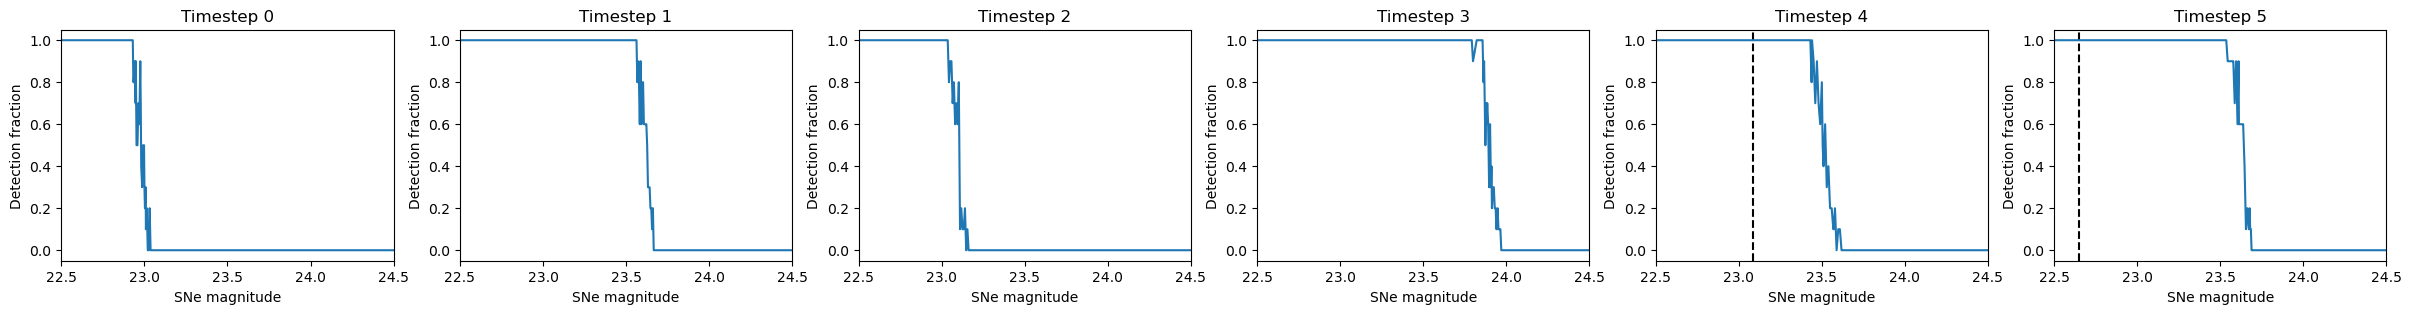

In [37]:
plt.figure(figsize = (len(dfs)*5,3))

for i,df_recovery in enumerate(dfs):

    plt.subplot(1, len(dfs), i+1)
    sn_mag = df_exposure['sn_mag_new'][i]
    plt.axvline(sn_mag, c = 'k', ls = '--')
    
    plt.plot(df_recovery['sn_mag'], df_recovery['detected'])
    plt.ylabel('Detection fraction')
    plt.xlabel('SNe magnitude')

    plt.xlim(22.5,24.5)
    plt.title(f'Timestep {i}')
    
plt.show()

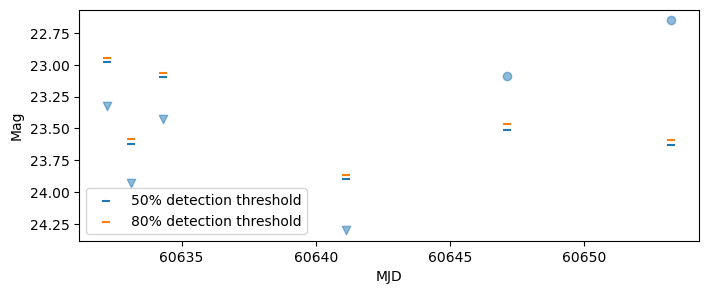

In [34]:
plt.figure(figsize = (8,3))

for ft in fraction_thresholds: # Plot the detection fractions
    plt.scatter(df_exposure['expMidptMJD'], df_exposure[f'lim_{ft}'], label = fr'{ft*100:.0f}% detection threshold', marker = '_')

for i in range(len(df_exposure)):
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['sn_mag_new'][i], alpha = 0.5, c = 'C0')
    else:
        plt.scatter(df_exposure['expMidptMJD'][i], df_exposure['5sigma_mag'][i], marker = 'v', alpha = 0.5, c = 'C0')

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')
plt.legend()
plt.show()